In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
classes = 10
plt.style.use('seaborn')
label_names =  ["airplane",
                "automobile",
                "bird",
                "cat",
                "deer",
                "dog",
                "frog", 
                "horse",
                "ship",
                "truck"]

In [3]:
# Transformations
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=classes)

# dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, transform = t, target_transform=target_t, download=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, transform = t, target_transform=target_t, download=True)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Visualizing the images in datatset


Visualizig image in dataset


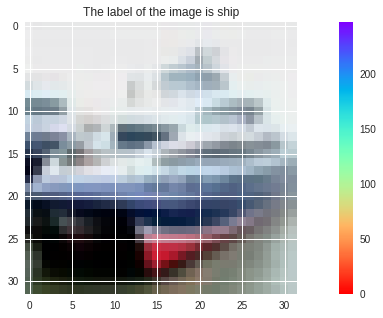

In [6]:
# Plot multiple images from the dataset

# Reversing the normalization 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = next(iter(test_loader))[0][1].permute(1,2,0)
img = (img * std + mean) * 255

# Getting the label
label = next(iter(test_loader))[1][1].argmax()

def visual(img, label):
    print("Visualizig image in dataset")

    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.rainbow_r)

    fig.colorbar(im)
    ax.set_title(f"The label of the image is {label}")

    
visual(img.type(torch.uint8), label_names[label])
# print(label_names[torch.argmax(label)])

## Task 1
Getting  model from last assignment, training it on CIFAR-10 dataset and checking its performance in compariosn to a CNN model later defined in code 

In [7]:
class CIFAR10Mlp(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.input_dims = 3072
        self.layer1 = nn.Linear(in_features=3072, out_features=732)
        self.layer2 = nn.Linear(in_features=732, out_features=824)
        self.layer3 = nn.Linear(in_features=824, out_features=10)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        
        x = self.layer3(x)
        pred = F.log_softmax(x, dim=1)
        return x

In [8]:
class Network(nn.Module):
    """
    This is the CNN architecture to evaluate CIFAR-10 dataset
    """
    def __init__(self, name: str, normalization: str):
        super().__init__()
        
        self.name = name
        self.normalization = normalization
        # Block 1 
        
        # Input: (3, 32, 32)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        # RelU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Relu
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64 X 16 X 16

        # Block 2: 
        # Input: 64 X 16 X 16
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # RelU
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Relu
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128 X 8 X 8

        # Block 3: 
        # Input: 128 X 4 X 4
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        # RelU
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        # Relu
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 256 X 4 X 4

        # Dense layer
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
        if self.normalization == "batch":
            self.conv2_bn = nn.BatchNorm2d(64)
            self.conv4_bn = nn.BatchNorm2d(128)
            self.conv6_bn = nn.BatchNorm2d(256)
            self.fc1_bn = nn.BatchNorm1d(1024)
            self.fc2_bn = nn.BatchNorm1d(512)
        
        if self.normalization == "group":
            self.conv2_group = nn.GroupNorm(8, 64)
            self.conv4_group = nn.GroupNorm(16, 128)
            self.conv6_group = nn.GroupNorm(32, 256)

        if self.normalization == "dropout":
            self.in_dropout = nn.Dropout(p=0.2)
            self.cnn_dropout = nn.Dropout(p=0.5)
            self.lin_dropout = nn.Dropout(p=0.5)
        
        
    def forward(self, x):
        if self.normalization == "dropout":
            x = self.in_dropout(x)
            
            x = F.relu(self.conv1(x))
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv2(x))))
            x = F.relu(self.conv3(x))
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv4(x))))
            x = F.relu(self.conv5(x))
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv6(x))))
            
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.lin_dropout(self.fc1(x)))
            x = F.relu(self.lin_dropout(self.fc2(x)))
            x = self.fc3(x)
            
        elif self.normalization == "batch":
            x = F.relu(self.conv1(x))
            x = self.maxpool(F.relu(self.conv2_bn(self.conv2(x))))
            x = F.relu(self.conv3(x))
            x = self.maxpool(F.relu(self.conv4_bn(self.conv4(x))))
            x = F.relu(self.conv5(x))
            x = self.maxpool(F.relu(self.conv6_bn(self.conv6(x))))
            
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1_bn(self.fc1(x)))
            x = F.relu(self.fc2_bn(self.fc2(x)))
            x = self.fc3(x)
            
        elif self.normalization == "group":
            x = F.relu(self.conv1(x))
            x = self.maxpool(F.relu(self.conv2_group(self.conv2(x))))
            x = F.relu(self.conv3(x))
            x = self.maxpool(F.relu(self.conv4_group(self.conv4(x))))
            x = F.relu(self.conv5(x))
            x = self.maxpool(F.relu(self.conv6_group(self.conv6(x))))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        
        elif self.normalization == "no":
            x = F.relu(self.conv1(x))
            x = self.maxpool(F.relu(self.conv2(x)))
            x = F.relu(self.conv3(x))
            x = self.maxpool(F.relu(self.conv4(x)))
            x = F.relu(self.conv5(x))
            x = self.maxpool(F.relu(self.conv6(x)))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x
    

In [9]:
def train_epoch(model, train_loader, optimizer, criterion, epoch):
    loss_list = []
    running_loss = 0.0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, (data, target) in pbar:
        data, target = data.to(device), target.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss =+ loss.item()
        loss_list.append(loss.item())

        if idx % 5 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")
    avg_loss = np.mean(loss_list)
    return loss_list, avg_loss


def testing(model, test_loader, criterion):
    model.eval()
    total_corr = 0
    loss_list = []
    with torch.no_grad():
        total_corr = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = model(data)
            
            loss = criterion(output, target)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
            loss_list.append(loss.item())
            
    accuracy = (total_corr/len(test_dataset))
    
    return accuracy, np.mean(loss_list)

def training(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
#     Training time per epoch calculate and display
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "valid_acc": [],
        "loss_iters":[]
    }
    
    for epoch in range(num_epochs):
        stats["epoch"].append(epoch + 1)
        # training 
        epoch_loss_list, epoch_loss = train_epoch(model, train_loader, optimizer, criterion, epoch)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
        
        # testing
        acc, v_loss = testing(model, test_loader, criterion)        
        stats["valid_acc"].append(acc.item())
        stats["val_loss"].append(v_loss)
        
        if (epoch+1) % 3 == 0 or (epoch+1) == num_epochs:
            saving_model(model, optimizer, epoch, stats)
            print(f"Accuracy for epoch: {epoch+1} is ", stats["valid_acc"][-1])


In [10]:
# util functions 
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/{model.name}_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats


In [11]:
def training_full_model(model_type: str, name: str, normalization: str, train_loader, valid_loader, num_epochs):
    if model_type == "cnn":
        model = Network(name, normalization).to(device)
    elif model_type == "mlp":
        model = CIFAR10Mlp(name).to(device)
    summary(model.to(device), (3,32,32))
    LR = 3e-4
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs)

## Training models


In [12]:
%time training_full_model(model_type="mlp", name="mlp", normalization=None, train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 732]       2,249,436
              ReLU-2                  [-1, 732]               0
            Linear-3                  [-1, 824]         603,992
              ReLU-4                  [-1, 824]               0
            Linear-5                   [-1, 10]           8,250
Total params: 2,861,678
Trainable params: 2,861,678
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 10.92
Estimated Total Size (MB): 10.95
----------------------------------------------------------------


Epoch 3, Itr 96, Loss 1.30777: 100%|████████████| 98/98 [00:02<00:00, 44.73it/s]


Accuracy for epoch: 3 is  0.5166999697685242


Epoch 6, Itr 96, Loss 1.10355: 100%|████████████| 98/98 [00:02<00:00, 43.64it/s]


Accuracy for epoch: 6 is  0.5388000011444092


Epoch 9, Itr 96, Loss 0.78444: 100%|████████████| 98/98 [00:02<00:00, 42.08it/s]


Accuracy for epoch: 9 is  0.5645999908447266


Epoch 12, Itr 96, Loss 0.68521: 100%|███████████| 98/98 [00:02<00:00, 45.53it/s]


Accuracy for epoch: 12 is  0.5666999816894531


Epoch 15, Itr 96, Loss 0.67402: 100%|███████████| 98/98 [00:02<00:00, 45.50it/s]


Accuracy for epoch: 15 is  0.5674999952316284


Epoch 18, Itr 96, Loss 0.62861: 100%|███████████| 98/98 [00:02<00:00, 44.55it/s]


Accuracy for epoch: 18 is  0.5658999681472778
CPU times: user 13.1 s, sys: 5.81 s, total: 18.9 s
Wall time: 51.9 s


In [13]:
%time training_full_model(model_type="cnn", name="model_with_dropout", normalization="dropout", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 32, 32, 32]             896
            Conv2d-3           [-1, 64, 32, 32]          18,496
           Dropout-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
            Conv2d-7          [-1, 128, 16, 16]         147,584
           Dropout-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
           Conv2d-11            [-1, 256, 8, 8]         590,080
          Dropout-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
           Linear-14                 [-

Epoch 3, Itr 96, Loss 1.34692: 100%|████████████| 98/98 [00:12<00:00,  7.86it/s]


Accuracy for epoch: 3 is  0.41279998421669006


Epoch 6, Itr 96, Loss 1.04699: 100%|████████████| 98/98 [00:12<00:00,  7.84it/s]


Accuracy for epoch: 6 is  0.5199999809265137


Epoch 9, Itr 96, Loss 0.84524: 100%|████████████| 98/98 [00:12<00:00,  7.82it/s]


Accuracy for epoch: 9 is  0.5719000101089478


Epoch 12, Itr 96, Loss 0.86703: 100%|███████████| 98/98 [00:12<00:00,  7.77it/s]


Accuracy for epoch: 12 is  0.5916999578475952


Epoch 15, Itr 96, Loss 0.86693: 100%|███████████| 98/98 [00:12<00:00,  7.79it/s]


Accuracy for epoch: 15 is  0.5909000039100647


Epoch 18, Itr 96, Loss 0.89686: 100%|███████████| 98/98 [00:12<00:00,  7.79it/s]


Accuracy for epoch: 18 is  0.5960999727249146
CPU times: user 3min 59s, sys: 5.69 s, total: 4min 5s
Wall time: 4min 4s


In [14]:
%time training_full_model(model_type="cnn", name="model_without_dropout", normalization="no", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
            Conv2d-8            [-1, 256, 8, 8]         590,080
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                 [-1, 1024]       4,195,328
           Linear-11                  [-1, 512]         524,800
           Linear-12                   [-1, 10]           5,130
Total params: 5,851,338
Trainable params: 5,851,338
Non-trainable params: 0
---------------------------

Epoch 3, Itr 96, Loss 1.32228: 100%|████████████| 98/98 [00:12<00:00,  8.06it/s]


Accuracy for epoch: 3 is  0.5406000018119812


Epoch 6, Itr 96, Loss 0.90267: 100%|████████████| 98/98 [00:12<00:00,  8.06it/s]


Accuracy for epoch: 6 is  0.647599995136261


Epoch 9, Itr 96, Loss 0.79663: 100%|████████████| 98/98 [00:12<00:00,  8.07it/s]


Accuracy for epoch: 9 is  0.7048999667167664


Epoch 12, Itr 96, Loss 0.69509: 100%|███████████| 98/98 [00:12<00:00,  8.07it/s]


Accuracy for epoch: 12 is  0.7138999700546265


Epoch 15, Itr 96, Loss 0.56476: 100%|███████████| 98/98 [00:12<00:00,  8.04it/s]


Accuracy for epoch: 15 is  0.7188999652862549


Epoch 18, Itr 96, Loss 0.65011: 100%|███████████| 98/98 [00:12<00:00,  8.04it/s]


Accuracy for epoch: 18 is  0.7202000021934509
CPU times: user 3min 53s, sys: 5.26 s, total: 3min 58s
Wall time: 3min 57s


In [15]:
%time training_full_model(model_type="cnn", name="model_with_batch", normalization="batch", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
            Conv2d-6          [-1, 128, 16, 16]         147,584
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
           Conv2d-10            [-1, 256, 8, 8]         590,080
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                 [-1, 1024]       4,195,328
      BatchNorm1d-14                 [-

Epoch 3, Itr 96, Loss 0.46758: 100%|████████████| 98/98 [00:12<00:00,  7.55it/s]


Accuracy for epoch: 3 is  0.6575999855995178


Epoch 6, Itr 96, Loss 0.18989: 100%|████████████| 98/98 [00:13<00:00,  7.54it/s]


Accuracy for epoch: 6 is  0.7450999617576599


Epoch 9, Itr 96, Loss 0.00918: 100%|████████████| 98/98 [00:12<00:00,  7.54it/s]


Accuracy for epoch: 9 is  0.8068000078201294


Epoch 12, Itr 96, Loss 0.00461: 100%|███████████| 98/98 [00:13<00:00,  7.54it/s]


Accuracy for epoch: 12 is  0.8095999956130981


Epoch 15, Itr 96, Loss 0.00342: 100%|███████████| 98/98 [00:12<00:00,  7.56it/s]


Accuracy for epoch: 15 is  0.8109999895095825


Epoch 18, Itr 96, Loss 0.00339: 100%|███████████| 98/98 [00:12<00:00,  7.54it/s]


Accuracy for epoch: 18 is  0.8101999759674072
CPU times: user 4min 8s, sys: 5.62 s, total: 4min 14s
Wall time: 4min 13s


In [16]:
%time training_full_model(model_type="cnn", name="model_with_group", normalization="group", train_loader=train_loader, valid_loader=test_loader, num_epochs=18)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
         GroupNorm-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
            Conv2d-6          [-1, 128, 16, 16]         147,584
         GroupNorm-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
           Conv2d-10            [-1, 256, 8, 8]         590,080
        GroupNorm-11            [-1, 256, 8, 8]             512
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                 [-1, 1024]       4,195,328
           Linear-14                  [

Epoch 3, Itr 96, Loss 0.77599: 100%|████████████| 98/98 [00:13<00:00,  7.45it/s]


Accuracy for epoch: 3 is  0.6970999836921692


Epoch 6, Itr 96, Loss 0.51069: 100%|████████████| 98/98 [00:13<00:00,  7.46it/s]


Accuracy for epoch: 6 is  0.7430999875068665


Epoch 9, Itr 96, Loss 0.13439: 100%|████████████| 98/98 [00:13<00:00,  7.44it/s]


Accuracy for epoch: 9 is  0.7799999713897705


Epoch 12, Itr 96, Loss 0.09782: 100%|███████████| 98/98 [00:13<00:00,  7.45it/s]


Accuracy for epoch: 12 is  0.7782999873161316


Epoch 15, Itr 96, Loss 0.06448: 100%|███████████| 98/98 [00:13<00:00,  7.47it/s]


Accuracy for epoch: 15 is  0.7809000015258789


Epoch 18, Itr 96, Loss 0.05592: 100%|███████████| 98/98 [00:13<00:00,  7.46it/s]


Accuracy for epoch: 18 is  0.7805999517440796
CPU times: user 4min 12s, sys: 5.47 s, total: 4min 17s
Wall time: 4min 16s


### Loading a model from disk


In [17]:
best_mlp = CIFAR10Mlp(name="mlp")
best_dropout = Network(name="best_dropout", normalization="dropout")
best_batch = Network(name="best_batch", normalization="batch")
best_group = Network(name="best_group", normalization="group")
best_no_dropout = Network(name="best_no_dropout", normalization="no")

best_mlp, _, _, stats_mlp = loading_model(best_mlp, "models/mlp_18.pth")
best_dropout, _, _, stats_d = loading_model(best_dropout, "models/model_with_dropout_18.pth")
best_no_dropout, _, _, stats_no_d = loading_model(best_no_dropout, "models/model_without_dropout_18.pth")
best_batch, _, _, stats_batch = loading_model(best_batch, "models/model_with_batch_18.pth")
best_group, _, _, stats_group = loading_model(best_group, "models/model_with_group_18.pth")

# Comparison Plots for various models

## 1. Comparing MLP with basic CNN model

The plots shown below are between Training and Validation loss for MLP and a basic CNN architecture without any Normalization.

It can be seen here that the MLP model on the left is heavily overfitted on the training data as the training loss keeps on decreasing and the validation loss first slightly decreases and then after epoch 8 the validation loss keeps increasing indiating that the model is overfitting on the training data and is not generalizing over the task

Whereas the model on the right is perfect example of how the model should be learning. Although the training and validation losses are not very less (as compared to model with batch norm as normalization) but the gap between training and validation loss is pretty small indicating that the model is generalizing over the task and not overfitting on the training dataset 

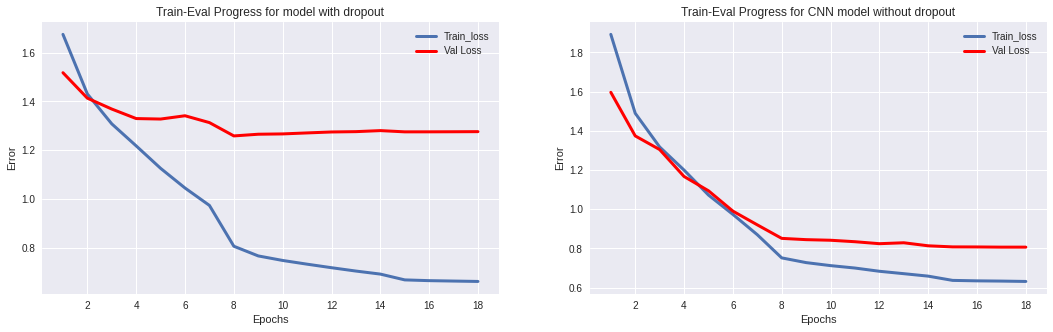

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(stats_mlp['epoch'], stats_mlp['train_loss'], label="Train_loss", linewidth=3)
ax[0].plot(stats_mlp['epoch'], stats_mlp['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].set_xticks(np.arange(2, 19, step=2))

ax[0].set_title("Train-Eval Progress for model with dropout")


ax[1].plot(stats_no_d['epoch'], stats_no_d['train_loss'], label="Train_loss", linewidth=3)
ax[1].plot(stats_no_d['epoch'], stats_no_d['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].set_xticks(np.arange(2, 19, step=2))

ax[1].set_title("Train-Eval Progress for CNN model without dropout")

plt.show()

In [32]:
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(18, 5)

# ax[0].plot(stats_mlp['epoch'][-10:], stats_mlp['train_loss'][-10:], label="Train_loss", linewidth=3)
# ax[0].plot(stats_mlp['epoch'][-10:], stats_mlp['val_loss'][-10:], label="Val Loss", c='red', linewidth=3)
# ax[0].legend(loc='best')
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Error")

# ax[0].set_title("Train-Eval Progress for model with dropout")


# ax[1].plot(stats_no_d['epoch'][-10:], stats_no_d['train_loss'][-10:], label="Train_loss", linewidth=3)
# ax[1].plot(stats_no_d['epoch'][-10:], stats_no_d['val_loss'][-10:], label="Val Loss", c='red', linewidth=3)
# ax[1].legend(loc='best')
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Error")
# # ax[1].set_xticks(np.arange(2, 11, step=2))

# ax[1].set_title("Train-Eval Progress for CNN model without dropout")

# plt.show()

## 2.Comparing different Normalization techiques

### a. Comapring training loss for all normalization techniques

Below are the trianing and validation plots for different normalization techniques. 

Below are some observations that we made:

* The model with dropout had high training and val loss, the only reasonal answer to this is that dropout encourages Network to ignore or "drop out" some number of neurons in a layer. So higher training loss is understandable but the normal technique of training for a longer period of time won't seem to work here since the loss isn't decreasing and this model is likely to cause generalization issue as the gap in training and val loss is quite a lot 


* Model without dropout performed significantly better than we thought, the training and val loss were less. I believe if we trained it for longer number of epochs then these losses would have diverged and the model would have started to overfit but for this length of training the model performed great


* For batch norm the plot looked quite unique where the validation loss first incresed and then decreased sharply at epoch 8 and then became stegnant. And the training loss around the same epoch number was negligible. Quantitatively the validation loss was the least as compared to other models but the gap between the two losses shows that there is heavy overfitting


* Similar trend of slight increase in validation loss at epoch 4 and 6 is observed here as well. And later from epoch 8 the model clearly went for overfitting where the validation loss incresed and training loss became negligibly low

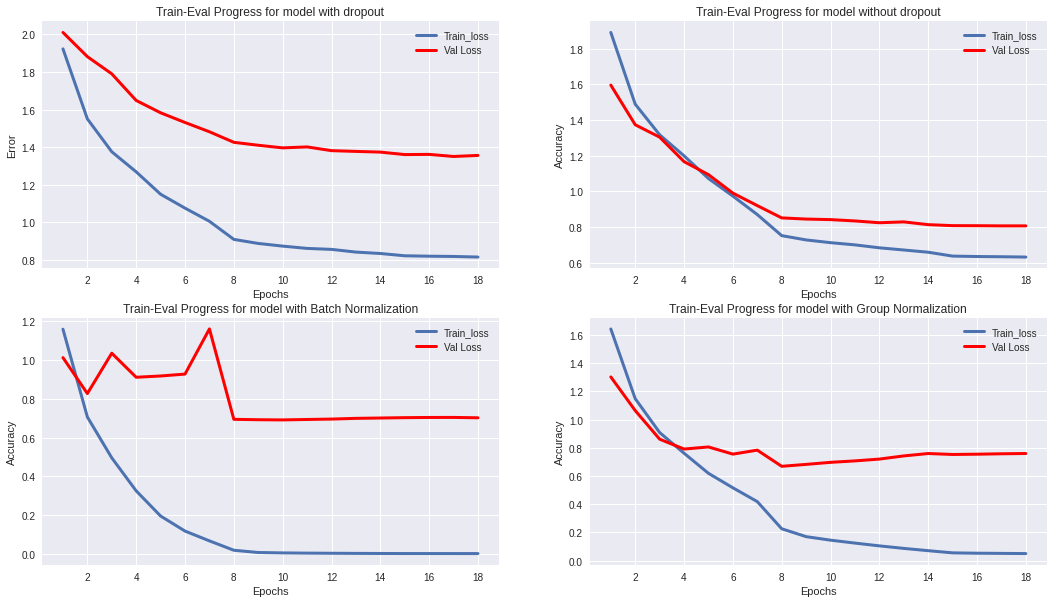

In [33]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18, 10)

ax[0][0].plot(stats_d['epoch'], stats_d['train_loss'], label="Train_loss", linewidth=3)
ax[0][0].plot(stats_d['epoch'], stats_d['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Error")
ax[0][0].set_xticks(np.arange(2, 19, step=2))

ax[0][0].set_title("Train-Eval Progress for model with dropout")

ax[0][1].plot(stats_no_d['epoch'], stats_no_d['train_loss'], label="Train_loss", linewidth=3)
ax[0][1].plot(stats_no_d['epoch'], stats_no_d['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_xticks(np.arange(2, 19, step=2))

ax[0][1].set_title("Train-Eval Progress for model without dropout")

ax[1][0].plot(stats_batch['epoch'], stats_batch['train_loss'], label="Train_loss", linewidth=3)
ax[1][0].plot(stats_batch['epoch'], stats_batch['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Accuracy")
ax[1][0].set_xticks(np.arange(2, 19, step=2))

ax[1][0].set_title("Train-Eval Progress for model with Batch Normalization")


ax[1][1].plot(stats_group['epoch'], stats_group['train_loss'], label="Train_loss", linewidth=3)
ax[1][1].plot(stats_group['epoch'], stats_group['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_xticks(np.arange(2, 19, step=2))

ax[1][1].set_title("Train-Eval Progress for model with Group Normalization")

plt.show()

### b. Accuracy for different models

* As expected the accuracy for Batch norm was the highest as compared to others since the loss was the smallest for this model. There was a unique trend in the beginning where we observed the rise in val loss but then things went back normal again


* Although the model with group norm as regulrization was overfitting at later stages, as per accuracy the model performed 2nd best 


* Secondly what is interesting is the plot itself the trend of sudden rise in accuracy and then slowly plateauing is similar in all cases.


* There isn't one model which showed potential of having more accuracy if it was trained for longer


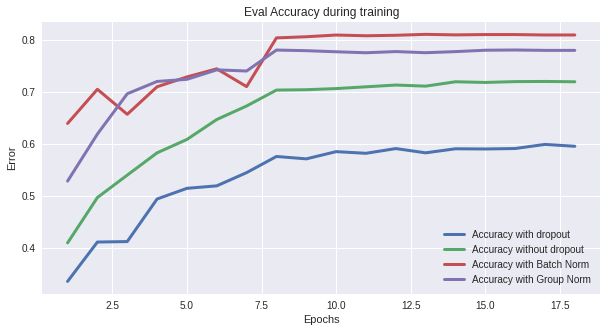

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

ax.plot(stats_d['epoch'], stats_d['valid_acc'], label="Accuracy with dropout", linewidth=3)
ax.plot(stats_no_d['epoch'], stats_no_d['valid_acc'], label="Accuracy without dropout", linewidth=3)
ax.plot(stats_batch['epoch'], stats_batch['valid_acc'], label="Accuracy with Batch Norm", linewidth=3)
ax.plot(stats_group['epoch'], stats_group['valid_acc'], label="Accuracy with Group Norm", linewidth=3)

ax.legend(loc='best')
ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
    
ax.set_title("Eval Accuracy during training")

plt.show()

### c. Comparing time

Below is a plot which shows the accuracy v/s time of training of all the models

* MLP took the least time to train and had the least accuracy

* CNN models all took reletively same time to train

* Group norm took the longest to train but had relatively high accuracy

* Out of the CNN models model with dropout had the least accuracy

* Model with Batch Norm had the highes

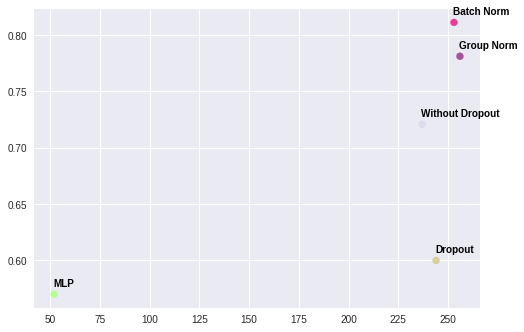

In [81]:
model_names = ["MLP", "Dropout", "Without Dropout", "Batch Norm", "Group Norm"]
training_time_seconds = [51.9, 244, 237, 253, 256]
combined_stats = [stats_mlp, stats_d, stats_no_d, stats_batch, stats_group]
acc = [np.array(i['valid_acc']).max() for i in combined_stats]
colormap = np.random.uniform(low=0.0, high=1.0, size=(5,4))

categories = np.arange(5)

plt.scatter(training_time_seconds, acc, c=colormap[categories])
for i in range(len(model_names)):
    plt.text(training_time_seconds[i]-0.5, acc[i]+0.007, s=model_names[i], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

In [62]:
color1 = (0.1251, 0.2255, 0.65484, 1.0)
color2 = (0.1251, 0.2255, 0.65484, 1.0)
colormap = np.array([color1, color2])
catt = np.array([0, 1])


(2,)


# 3. Visualizing the kernels

In [21]:
#Function for plottinng kernels and activation maps
def plot(tensor, plot_kernels, n_cols=10):
    n_kernels = tensor.shape[0]
    n_rows = 1+ n_kernels // n_cols
    fig = plt.figure(figsize=(n_cols,n_rows))
    for i in range(n_kernels):
        ax1 = fig.add_subplot(n_rows,n_cols,i+1)
        if plot_kernels==True:
            ax1.imshow(tensor[i][0,:,:].cpu(),cmap='gray')
        else:
            ax1.imshow(tensor[i],cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

Kernel Visualization
torch.Size([32, 3, 3, 3])


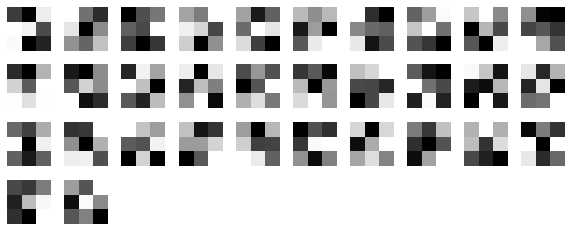

AttributeError: 'MaxPool2d' object has no attribute 'weight'

In [22]:
print("Kernel Visualization")
filters = best_no_dropout.modules()
model_layers = [i for i in best_no_dropout.children()]
first_layer = model_layers[0]
second_layer = model_layers[2]

first_kernels = first_layer.weight.data.clone()
print(first_kernels.shape)
plot(first_kernels,True)


second_kernels = second_layer.weight.data.clone()
print(second_kernels.shape)
plot(second_kernels,True)

This shows the kernel visualization. Our kernels are of sizes 5 x 5, hence we can see a grid of the same size. The dark boxes indicate that the weights are of lower magnitude and the light ones indicate the weights are of greater magnitude. As the patches go from dark to light, the weight values keep increasing.



## Visualization of Activations 

Activation Visualization
Convolutional Output Layer - 1


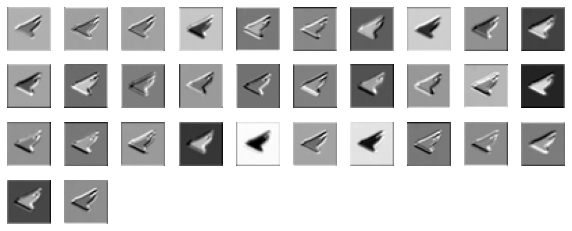

After first convolution and maxpool layer torch.Size([32, 16, 16])


RuntimeError: shape '[-1, 1176]' is invalid for input of size 8192

In [23]:
print("Activation Visualization")   
img, label = test_dataset[21]
img_input = img.unsqueeze(0)

result1 = best_no_dropout.conv1(img_input)
result1 = result1.squeeze()

print('Convolutional Output Layer - 1')
plot(result1.data.numpy(),False)
      
result1 = best_no_dropout.maxpool(result1)
print("After first convolution and maxpool layer",result1.shape)           


result1 = (result1.view(-1, 6*14*14))
resized_img = result1[0].view(1, 6, 14, 14)

result2 = best_no_dropout.conv2(resized_img)
result2 = result2.squeeze()
      
print('Convolutional Output Layer - 2')
plot(result2.data.cpu().numpy(),False)
result2 = best_no_dropout.maxpool(result2)
print("After second convolution and maxpool layer",result2.shape)   

These are our activation maps after the first and second convolution layers. After the first convolution layer, the activation maps highlight the image involved by either darkening/lightning the image. It is difficult to understand what the second layer is trying to achieve.

# Early Stopping Criterion

In [ ]:
def early_stopping(cur_val_loss,val_best_loss,stop_counter,stop_counter_limit):
    if val_best_loss < cur_val_loss:
        stop_counter+=1
        if stop_counter>stop_counter_limit:
            return True,stop_counter

    return False,stop_counter